# Analyse de la fraude triangulaire dans les données de trajets de covoiturage

[Introduction](#introduction)
  - Présentation du contexte et de l'objectif de l'analyse
  - Explication des données de trajets de covoiturage utilisées
  
[Chargement des données](#data)
 - Importation des bibliothèques nécessaires
 - Chargement des données de l'AOM et de la période spécifiées

[Détection des paires de changement de rôle](#pairs)
  - Création d'une fonction pour rechercher les paires de participants qui changent de rôle dans les trajets
  - Application de la fonction aux données de trajets pour identifier les paires suspectes

[Analyse des groupes frauduleux avec les graphes de connexion](#groups)
  - Création d'un graphe de connexion à partir des groupes suspects
  - Identification des groupes de participants frauduleux à l'aide des composantes connexes du graphe
  - Calcul des mesures de centralité pour évaluer l'importance des participants dans les groupes

[Rapport sur les groupes frauduleux détectés](#report)
 - Présentation des groupes frauduleux identifiés avec leurs caractéristiques (nombre de participants, durée des trajets, etc.)
 - Statistiques descriptives sur les groupes (nombre moyen de participants, durée moyenne des trajets, etc.)

[Conclusion](#conclusions)
 - Récapitulatif des principales conclusions de l'analyse
 - Discussion sur les implications et les recommandations éventuelles

## [Introduction](#introduction)
### Présentation du contexte et de l'objectif de l'analyse

Dans le cadre de cette analyse, nous nous intéressons aux données de trajets de covoiturage. Le covoiturage est devenu une alternative populaire pour les déplacements, offrant un moyen économique et écologique de se déplacer d'un endroit à un autre. Cependant, comme toute activité impliquant des interactions entre individus, il peut également être sujet à des comportements frauduleux.

L'objectif de cette analyse est de détecter les groupes de participants impliqués dans des activités frauduleuses dans les trajets de covoiturage. Nous cherchons à identifier les participants qui changent de rôle de manière suspecte, c'est-à-dire ceux qui passent de conducteur à passager ou vice versa de manière répétée et inhabituelle. En détectant ces paires de participants, nous pouvons explorer les connexions entre eux pour identifier les groupes frauduleux et en comprendre les schémas de comportement.

### Explication des données de trajets de covoiturage utilisées

Les données de trajets de covoiturage utilisées dans cette analyse comprennent des informations sur les trajets effectués dans une région spécifique pendant une période donnée. Chaque trajet est caractérisé par des détails tels que l'identifiant du trajet, la durée, la date et l'heure, l'identifiant de l'opérateur, l'identifiant du trajet ainsi que les numéros de téléphone tronqués des participants.

Ces données nous permettent de reconstituer les trajets effectués par les participants et d'analyser les interactions entre eux. En nous concentrant sur les changements de rôle suspects, nous pouvons détecter les groupes de participants qui pourraient être impliqués dans des activités frauduleuses.


## [Chargement des données](#data)
### Importation des bibliothèques nécessaires

In [1]:
import warnings
import os
import pandas as pd
import psycopg2
import numpy as np
import ast
import networkx as nx
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
load_dotenv()

True

### Chargement des données de l'AOM et de la période spécifiées

In [2]:
start_date = "2023-02-27 23:59:59"
end_date = "2023-04-30 00:00:01"
aom_insee = "217500016"
DATABASE = os.environ['DATABASE']
USER = os.environ['USER_DB']
PASSWORD = os.environ['PASSWORD']
PORT = os.environ['PORT']
con = psycopg2.connect(
    host="rw-278289c4-e688-4c87-932a-01b3e625fb6a.rdb.fr-par.scw.cloud",
    database=DATABASE,
    user=USER,
    password=PASSWORD,
    port=PORT,
    sslmode="require"
)

In [3]:
query = f"""SELECT cc._id, cc.is_driver, ci.phone_trunc, cc.datetime, cc.duration, cc.operator_id, cc.start_position, cc.operator_journey_id,cc.start_geo_code,cc.end_geo_code,
cc.end_position, gmap_url(cc.start_position, cc.end_position), CASE WHEN cc.is_driver THEN pa.rpc_driver_uuid ELSE pa.rpc_passenger_uuid END as rpc_uuid, pi.result
FROM CARPOOL.CARPOOLS cc
   join carpool.identities ci on cc.identity_id = ci._id
   join geo.perimeters gps on cc.start_geo_code = gps.arr and gps.year = 2022
   join geo.perimeters gpe on cc.end_geo_code = gpe.arr and gpe.year = 2022
   LEFT join phones.all pa on pa.operator_journey_id = cc.operator_journey_id
   LEFT JOIN policy.incentives pi on pi.carpool_id = cc._id and pi.policy_id = 459
WHERE CC.DATETIME >= '{start_date}'::timestamp AT TIME ZONE 'EUROPE/PARIS'
    AND cc.operator_id IN (3,4,9)
	AND CC.DATETIME < '{end_date}'::timestamp AT TIME ZONE 'EUROPE/PARIS'
    {f"and (gps.aom = '{aom_insee}' or gpe.aom = '{aom_insee}') and gps.year = 2022 and gpe.year = 2022" if aom_insee else ""}
"""
df_carpool = pd.read_sql(query, con)
df_carpool.head(10)   

,_id,is_driver,phone_trunc,datetime,duration,operator_id,start_position,operator_journey_id,start_geo_code,end_geo_code,end_position,gmap_url,rpc_uuid,result
0,34562403,True,+336373346,2023-04-25 04:50:55+00:00,2300,3,0101000020E6100000C993A46B269F05402A5778978B20...,f995db7f-86a4-4d70-8816-a1541e22136d,77333,91174,0101000020E6100000A1A17F828B9503403546EBA86A4E...,"https://www.google.com/maps/dir/48.25426,2.702...",None,300.0
1,34562404,False,+336692799,2023-04-25 04:50:55+00:00,2300,3,0101000020E6100000C993A46B269F05402A5778978B20...,f995db7f-86a4-4d70-8816-a1541e22136d,77333,91174,0101000020E6100000A1A17F828B9503403546EBA86A4E...,"https://www.google.com/maps/dir/48.25426,2.702...",None,NaN
2,34562413,True,+336567862,2023-04-25 04:34:26+00:00,3295,3,0101000020E6100000AC90F2936A9FFE3F5053CBD6FA7E...,d89364f2-27b3-457f-90a7-b52820484d48,78440,75107,0101000020E61000008CD651D504910240E162450DA66D...,"https://www.google.com/maps/dir/48.99203,1.913...",None,300.0
3,34562414,False,+336516785,2023-04-25 04:34:26+00:00,3295,3,0101000020E6100000AC90F2936A9FFE3F5053CBD6FA7E...,d89364f2-27b3-457f-90a7-b52820484d48,78440,75107,0101000020E61000008CD651D504910240E162450DA66D...,"https://www.google.com/maps/dir/48.99203,1.913...",None,NaN
4,34562441,True,+336255867,2023-04-25 05:03:13+00:00,1278,3,0101000020E6100000A1A17F828B150240A3586E693564...,2cf4b638-d5db-4a40-85d1-6c26225a9364,92060,92075,0101000020E6100000C5C9FD0E45410240E10B93A98269...,"https://www.google.com/maps/dir/48.78288,2.260...",None,150.0
5,34562442,False,+336277557,2023-04-25 05:03:13+00:00,1278,3,0101000020E6100000A1A17F828B150240A3586E693564...,2cf4b638-d5db-4a40-85d1-6c26225a9364,92060,92075,0101000020E6100000C5C9FD0E45410240E10B93A98269...,"https://www.google.com/maps/dir/48.78288,2.260...",None,NaN
6,34562449,True,+336304005,2023-04-25 04:37:56+00:00,3112,3,0101000020E61000008716D9CEF7530640CEC7B5A16230...,486a6b4e-4679-4754-aed5-cbea6b13a4ec,77316,77384,0101000020E6100000857CD0B35935054068226C787A4D...,"https://www.google.com/maps/dir/48.37801,2.791...",None,300.0
7,34562450,False,+336159829,2023-04-25 04:37:56+00:00,3112,3,0101000020E61000008716D9CEF7530640CEC7B5A16230...,486a6b4e-4679-4754-aed5-cbea6b13a4ec,77316,77384,0101000020E6100000857CD0B35935054068226C787A4D...,"https://www.google.com/maps/dir/48.37801,2.791...",None,NaN
8,34562453,True,+336269550,2023-04-25 04:47:42+00:00,2526,3,0101000020E6100000535C55F65D1102407E5704FF5B5D...,7892754e-3650-4f17-a9f0-e4875ec2c269,91377,77384,0101000020E6100000514EB4AB90320540DA722EC5554D...,"https://www.google.com/maps/dir/48.72937,2.258...",None,300.0
9,34562454,False,+336657345,2023-04-25 04:47:42+00:00,2526,3,0101000020E6100000535C55F65D1102407E5704FF5B5D...,7892754e-3650-4f17-a9f0-e4875ec2c269,91377,77384,0101000020E6100000514EB4AB90320540DA722EC5554D...,"https://www.google.com/maps/dir/48.72937,2.258...",None,NaN


### Exploration initiale des données (wip)

In [4]:
df_carpool.columns

Index(['_id', 'is_driver', 'phone_trunc', 'datetime', 'duration',
       'operator_id', 'start_position', 'operator_journey_id',
       'start_geo_code', 'end_geo_code', 'end_position', 'gmap_url',
       'rpc_uuid', 'result'],
      dtype='object')

In [5]:
df_carpool.shape

(1031808, 14)

## [Détection des paires de changement de rôle](pairs)
### Création d'une fonction pour rechercher les paires de participants qui changent de rôle dans les trajets

#### Méthdodologie :
 - Ajouter colonne conducteur ou passager en fonction de 'is_driver'.
 - Création variable unique phone_trunc avec rôle (conducteur ou passager).
 - Enumérer la liste des uniques phone_trunc avec rôle pour chaque operator_journey_id.
 - Aggréger par pair de phone_trunc.
 - Filtrer les pairs de phone_trunc qui ont une liste de rôle unique de taille plus grande que 2 = changement de rôle.

In [6]:
def find_potential_triangular_pairs(df):   
    get_role = lambda x: 'driver' if x else 'passenger'
    df['role'] = df['is_driver'].apply(get_role)
    df['temp'] = df['phone_trunc'] +'_'+ df['role']
    _temp = df.groupby('operator_journey_id').agg(lambda x: sorted(list(x))).reset_index()
    _temp['phone_trunc'] = _temp['phone_trunc'].astype(str)
    grouped = _temp.groupby('phone_trunc')[['temp','operator_journey_id']].agg(lambda x: list(x)).reset_index()
    _temp_1 = pd.DataFrame(grouped['temp'].explode().explode())
    _temp_1.reset_index(inplace=True)
    _temp_1.groupby('index').agg({'temp' : 'nunique'}).reset_index().temp
    grouped['roles_list'] = _temp_1.groupby('index').agg({'temp' : 'nunique'}).reset_index().temp
    potential_triangular = lambda x: True if x > 2 else False
    grouped['potential_triangular'] = grouped.roles_list.apply(potential_triangular)

    return grouped

### Application de la fonction aux données de trajets pour identifier les paires suspectes

In [7]:
triangular_df = find_potential_triangular_pairs(df_carpool)
triangular_df.head()

,phone_trunc,temp,operator_journey_id,roles_list,potential_triangular
0,"['+2135516266', '+336682118']","[[+2135516266_passenger, +336682118_driver], [...","[1q9anzl3-wqxu-14lw-77a9-uankkxza7a7a, 3n994w9...",2,False
1,"['+2626390561', '+336057739']","[[+2626390561_driver, +336057739_passenger], [...","[7nann94k-nucu-12n2-xu1q-ln2743w13xn7, 7zzzx9n...",2,False
2,"['+2626390561', '+337826001']","[[+2626390561_passenger, +337826001_driver], [...","[1c7wx3z1-a3k9-1cq4-xq9u-9uaw9w924u41, 2221w1c...",4,True
3,"['+2626922303', '+336355330']","[[+2626922303_driver, +336355330_passenger]]",[0a46507e-5970-48b8-bfe2-720f02e17553],2,False
4,"['+2626922303', '+336593624']","[[+2626922303_driver, +336593624_passenger]]",[9871c03d-5d2f-416a-a1bd-dd8e556854c1],2,False


In [8]:
# % de trajets potentiellement triangulaire
len(triangular_df[triangular_df.potential_triangular == True])/len(triangular_df)*100

11.257684426229508

## [Analyse des groupes frauduleux avec les graphes de connexion](#groups)

### Création d'un graphe de connexion à partir des groupes suspects

In [10]:
# filtrer df_carpool sur les phone_trunc potentiel à la fraude triangulaire
phone_numbers = triangular_df[triangular_df.potential_triangular ==  True]['phone_trunc'].to_list()
phone_truncs = []
for item in phone_numbers:
    numbers = ast.literal_eval(item)
    phone_truncs.extend(numbers)
    # Filter the original dataset based on phone truncs
filtered_df = df_carpool[df_carpool['phone_trunc'].isin(phone_truncs)]
filtered_df

,_id,is_driver,phone_trunc,datetime,duration,operator_id,start_position,operator_journey_id,start_geo_code,end_geo_code,end_position,gmap_url,rpc_uuid,result,role,temp
0,34562403,True,+336373346,2023-04-25 04:50:55+00:00,2300,3,0101000020E6100000C993A46B269F05402A5778978B20...,f995db7f-86a4-4d70-8816-a1541e22136d,77333,91174,0101000020E6100000A1A17F828B9503403546EBA86A4E...,"https://www.google.com/maps/dir/48.25426,2.702...",None,300.0,driver,+336373346_driver
1,34562404,False,+336692799,2023-04-25 04:50:55+00:00,2300,3,0101000020E6100000C993A46B269F05402A5778978B20...,f995db7f-86a4-4d70-8816-a1541e22136d,77333,91174,0101000020E6100000A1A17F828B9503403546EBA86A4E...,"https://www.google.com/maps/dir/48.25426,2.702...",None,NaN,passenger,+336692799_passenger
4,34562441,True,+336255867,2023-04-25 05:03:13+00:00,1278,3,0101000020E6100000A1A17F828B150240A3586E693564...,2cf4b638-d5db-4a40-85d1-6c26225a9364,92060,92075,0101000020E6100000C5C9FD0E45410240E10B93A98269...,"https://www.google.com/maps/dir/48.78288,2.260...",None,150.0,driver,+336255867_driver
5,34562442,False,+336277557,2023-04-25 05:03:13+00:00,1278,3,0101000020E6100000A1A17F828B150240A3586E693564...,2cf4b638-d5db-4a40-85d1-6c26225a9364,92060,92075,0101000020E6100000C5C9FD0E45410240E10B93A98269...,"https://www.google.com/maps/dir/48.78288,2.260...",None,NaN,passenger,+336277557_passenger
6,34562449,True,+336304005,2023-04-25 04:37:56+00:00,3112,3,0101000020E61000008716D9CEF7530640CEC7B5A16230...,486a6b4e-4679-4754-aed5-cbea6b13a4ec,77316,77384,0101000020E6100000857CD0B35935054068226C787A4D...,"https://www.google.com/maps/dir/48.37801,2.791...",None,300.0,driver,+336304005_driver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031798,34562267,True,+336796565,2023-04-25 04:40:38+00:00,2374,3,0101000020E61000004BAB21718FA506409B38B9DFA168...,732b27f6-5532-42f7-add7-3565c6fa0ade,77508,75112,0101000020E610000078EE3D5C725C0340431CEBE2366A...,"https://www.google.com/maps/dir/48.81744,2.830...",None,300.0,driver,+336796565_driver
1031799,34562268,False,+336214875,2023-04-25 04:40:38+00:00,2374,3,0101000020E61000004BAB21718FA506409B38B9DFA168...,732b27f6-5532-42f7-add7-3565c6fa0ade,77508,75112,0101000020E610000078EE3D5C725C0340431CEBE2366A...,"https://www.google.com/maps/dir/48.81744,2.830...",None,NaN,passenger,+336214875_passenger
1031800,34562281,True,+336807797,2023-04-25 04:31:26+00:00,2664,3,0101000020E6100000F9BD4D7FF6A30240C1E270E65773...,e72c81fd-e3f6-4c38-b022-acdf5f5d500d,93070,78238,0101000020E61000003D61890794CDFD3FF853E3A59B7C...,"https://www.google.com/maps/dir/48.90112,2.330...",None,300.0,driver,+336807797_driver
1031802,34562309,True,+336607501,2023-04-25 04:43:35+00:00,2639,3,0101000020E6100000DF89592F86320240EFE6A90EB975...,efce80f2-f0be-4b01-8863-ee764f68b9b9,92009,78490,0101000020E610000078280AF489BCFF3FD122DBF97E66...,"https://www.google.com/maps/dir/48.91971,2.274...",None,300.0,driver,+336607501_driver


In [11]:
# petite vérif
set(filtered_df.phone_trunc.unique()) == set(np.unique(phone_truncs))

True

In [13]:
filtered_df.columns

Index(['_id', 'is_driver', 'phone_trunc', 'datetime', 'duration',
       'operator_id', 'start_position', 'operator_journey_id',
       'start_geo_code', 'end_geo_code', 'end_position', 'gmap_url',
       'rpc_uuid', 'result', 'role', 'temp'],
      dtype='object')

In [14]:
filtered_df_grouped = filtered_df.groupby(['operator_journey_id','duration','datetime','operator_id']).agg({'phone_trunc' : list })
filtered_df_grouped.reset_index(inplace=True)
filtered_df_grouped

,operator_journey_id,duration,datetime,operator_id,phone_trunc
0,000042b1-2f45-4d16-80c6-7f0d2f5ee951,1077,2023-03-17 18:52:09+00:00,3,"[+336148447, +337790268]"
1,0000d677-451a-4c59-9866-deeb65bc7fcd_2023-03-14,1517,2023-03-14 06:00:00+00:00,9,"[+336254472, +337681715]"
2,0000d677-451a-4c59-9866-deeb65bc7fcd_2023-03-21,1517,2023-03-21 06:00:00+00:00,9,"[+336254472, +337681715]"
3,00017e0e-8d25-4312-80f0-05e30db08401,4049,2023-03-09 10:59:33+00:00,3,"[+336282775, +336122914]"
4,000188bb-0d08-47e4-9e4e-a60505336624,2089,2023-04-17 06:38:52+00:00,3,"[+336383965, +336254534]"
...,...,...,...,...,...
214057,zzzwk9ca-qx1k-1x91-wx4c-nlaakl3quclk,1973,2023-03-17 11:30:27+00:00,4,"[+336093720, +336273941]"
214058,zzzxczzn-xq9c-13nu-x2w4-nlzuk29qlxx4,2054,2023-03-27 07:40:13+00:00,4,[+336238157]
214059,zzzzw431-91la-1979-xqxn-kk722zqaxq49,818,2023-03-23 23:45:20+00:00,4,[+337861332]
214060,zzzzz21k-nu2z-11nc-7wzx-xn2x7kx1cna2,1987,2023-03-12 14:55:00+00:00,4,"[+336659170, +337639437]"


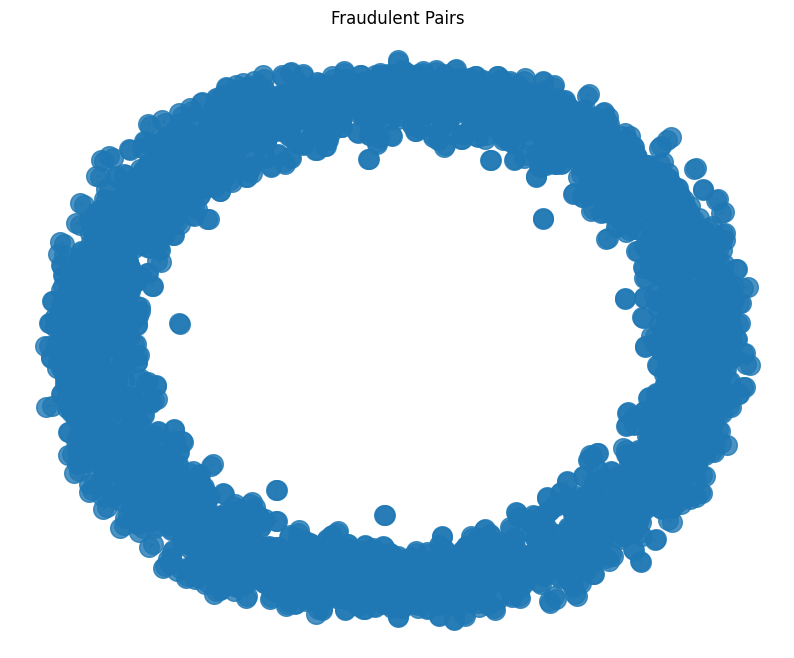

In [19]:
# graph for only the potential triangular for pairs
G = nx.Graph()
# Add edges between connected phone trunc
for _, row in filtered_df_grouped.iterrows():
    phone_list = row['phone_trunc']#.replace("'", "").replace("[", "").replace("]", "").split(", ")
    for i in range(len(phone_list) - 1):
        for j in range(i + 1, len(phone_list)):
            G.add_edge(phone_list[i], phone_list[j])

# Find connected components in the graph
connected_components = [component for component in nx.connected_components(G) if len(component) == 2]

# Visualize the groups
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
for component in connected_components:
    nx.draw_networkx_nodes(G, pos, nodelist=list(component), node_size=200, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=list(G.subgraph(component).edges()), width=1.5, alpha=0.5)

# Customize plot appearance
plt.axis('off')
plt.title('Fraudulent Pairs')
plt.show()


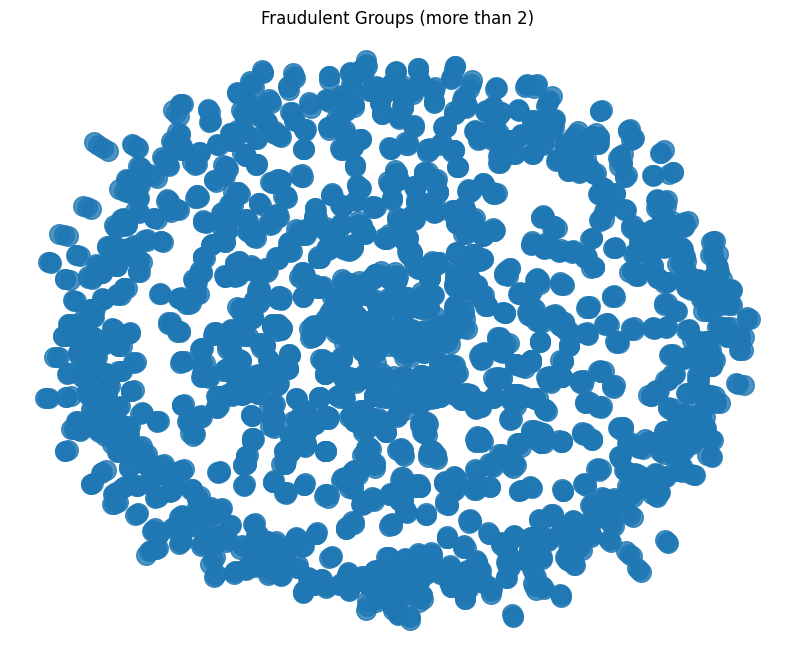

In [15]:
# graph for only the potential triangular for pairs
G = nx.Graph()
# Add edges between connected phone trunc
for _, row in filtered_df_grouped.iterrows():
    phone_list = row['phone_trunc']#.replace("'", "").replace("[", "").replace("]", "").split(", ")
    for i in range(len(phone_list) - 1):
        for j in range(i + 1, len(phone_list)):
            G.add_edge(phone_list[i], phone_list[j])

# Find connected components in the graph
connected_components = [component for component in nx.connected_components(G) if len(component) > 2]

# Visualize the groups
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
for component in connected_components:
    nx.draw_networkx_nodes(G, pos, nodelist=list(component), node_size=200, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=list(G.subgraph(component).edges()), width=1.5, alpha=0.5)

# Customize plot appearance
plt.axis('off')
plt.title('Fraudulent Groups (more than 2)')
plt.show()


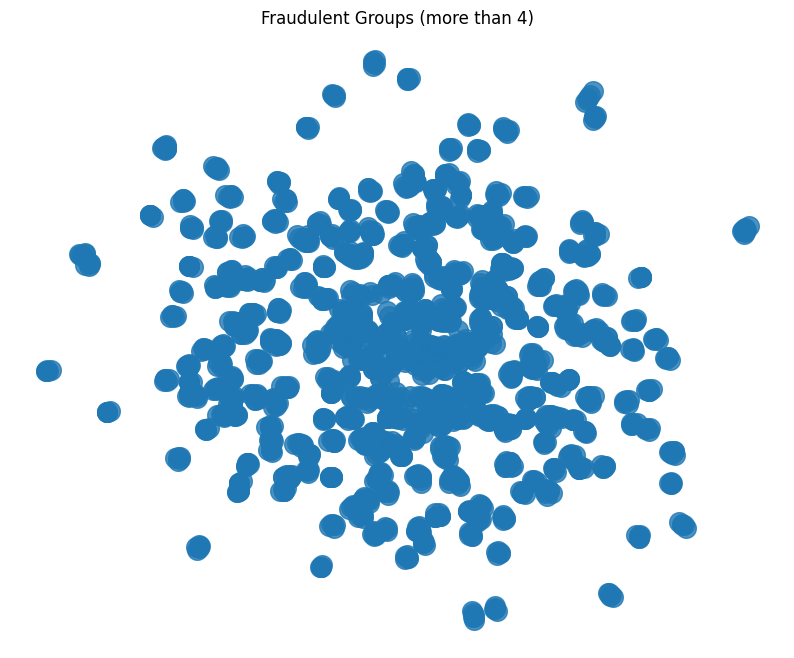

In [16]:
# graph for only the potential triangular for pairs
G = nx.Graph()
# Add edges between connected phone trunc
for _, row in filtered_df_grouped.iterrows():
    phone_list = row['phone_trunc']#.replace("'", "").replace("[", "").replace("]", "").split(", ")
    for i in range(len(phone_list) - 1):
        for j in range(i + 1, len(phone_list)):
            G.add_edge(phone_list[i], phone_list[j])

# Find connected components in the graph
connected_components = [component for component in nx.connected_components(G) if len(component) > 4]

# Visualize the groups
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw nodes and edges
for component in connected_components:
    nx.draw_networkx_nodes(G, pos, nodelist=list(component), node_size=200, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=list(G.subgraph(component).edges()), width=1.5, alpha=0.5)

# Customize plot appearance
plt.axis('off')
plt.title('Fraudulent Groups (more than 4)')
plt.show()


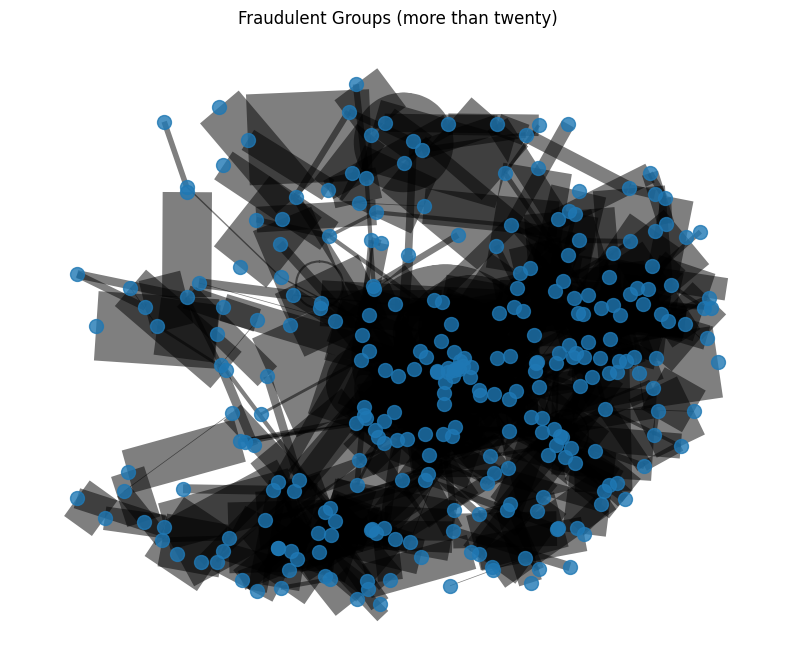

In [19]:
G = nx.Graph()

# Add edges between connected phone trunc
for _, row in filtered_df_grouped.iterrows():
    phone_list = row['phone_trunc']
    for i in range(len(phone_list) - 1):
        for j in range(i + 1, len(phone_list)):
            if G.has_edge(phone_list[i], phone_list[j]):
                G[phone_list[i]][phone_list[j]]['interactions'] += 1
            else:
                G.add_edge(phone_list[i], phone_list[j], interactions=1)

# Find connected components in the graph
connected_components = [component for component in nx.connected_components(G) if len(component) > 20]

# Visualize the groups
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.1)

# Calculate line widths based on interactions
edge_widths = [0.5 * G[u][v]['interactions'] for u, v in G.edges()]

# Draw nodes and edges
for component in connected_components:
    nx.draw_networkx_nodes(G, pos, nodelist=list(component), node_size=100, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=list(G.subgraph(component).edges()), width=edge_widths, alpha=0.5)

# Add labels to nodes
labels = {node: node for node in G.nodes() if node in connected_components}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='white')

# Customize plot appearance
plt.axis('off')
plt.title('Fraudulent Groups (more than twenty)')
plt.show()

## [Rapport sur les groupes frauduleux détectés](#report)

### Présentation des groupes frauduleux identifiés avec leurs caractéristiques (nombre de participants, durée des trajets, etc.)

In [16]:
G = nx.Graph()

# Add edges between connected phone trunc
for _, row in filtered_df_grouped.iterrows():
    phone_list = row['phone_trunc']
    for i in range(len(phone_list) - 1):
        for j in range(i + 1, len(phone_list)):
            if G.has_edge(phone_list[i], phone_list[j]):
                G[phone_list[i]][phone_list[j]]['interactions'] += 1
            else:
                G.add_edge(phone_list[i], phone_list[j], interactions=1)

# Find connected components in the graph
#connected_components = [component for component in nx.connected_components(G) if len(component) > 2]
connected_components = nx.connected_components(G)

# Create DataFrame with groups
group_data = []
group_degree_centrality = []
group_betweenness_centrality = []

for idx, component in enumerate(connected_components):
    group_graph = G.subgraph(component)
    degree_centrality = nx.degree_centrality(group_graph)
    betweenness_centrality = nx.betweenness_centrality(group_graph)

    group_phones = list(component)
    
    group_journeys = df_carpool[df_carpool['phone_trunc'].isin(group_phones)]
    group_duration = group_journeys['duration'].mean()//60
    group_operator_id = group_journeys['operator_journey_id']
    group_incentives = group_journeys['result']
    group_start_date = group_journeys['datetime'].min().date()
    group_end_date = group_journeys['datetime'].max().date()
    group_journeys['date'] = group_journeys['datetime'].dt.date
    grouped = group_journeys.groupby('phone_trunc').size().reset_index(name='count')
    
    group_data.append({
        'Group': idx+1,
        'Phone Numbers': group_phones,
        'Phone Trunc Count': len(group_phones),
        'Journeys Count': len(group_journeys.operator_journey_id.unique()),
        'Operator Id' : group_journeys.operator_id.unique(),
        'Number of Operator Id' : len(group_journeys.operator_id.unique()),
        'Mean duration (min)': group_duration,
        'Start Date': group_start_date,
        'End Date': group_end_date,
        'Daily mean trips' : group_journeys.drop_duplicates('operator_journey_id')['datetime'].dt.date.value_counts().sort_index().mean(),
        'Participant(s) central' : degree_centrality,
        'Participant(s) intermédiare' : betweenness_centrality,
        'operator_journey_id' : group_operator_id,
        'incentives' : group_incentives,
        'id_max_occurence': grouped.loc[grouped['count'].idxmax(),'phone_trunc'],
        'mean_per_day_id_max_occurence' : grouped.loc[grouped['count'].idxmax(),'count']/len(group_journeys.groupby('date'))
      
    })

groups_df = pd.DataFrame(group_data)

# Print the DataFrame
groups_df


,Group,Phone Numbers,Phone Trunc Count,Journeys Count,Operator Id,Number of Operator Id,Mean duration (min),Start Date,End Date,Daily mean trips,Participant(s) central,Participant(s) intermédiare,operator_journey_id,incentives,id_max_occurence,mean_per_day_id_max_occurence
0,1,"[+336148447, +337790268, +336845826]",3,28,"[4, 3]",2,29.0,2023-03-01,2023-04-28,1.866667,"{'+336148447': 1.0, '+337790268': 0.5, '+33684...","{'+336148447': 1.0, '+337790268': 0.0, '+33684...",37023 w1l9q192-97z1-19un-xqzz-n7k2wx7941uz...,37023 300.0 37024 NaN 45740 300....,+336148447,1.866667
1,2,"[+336254472, +337681715]",2,104,[9],1,25.0,2023-02-28,2023-04-29,1.925926,"{'+336254472': 1.0, '+337681715': 1.0}","{'+336254472': 0.0, '+337681715': 0.0}",947 efb99d4c-0ddf-40d5-85d5-4757b2b2082...,947 252.0 948 NaN 3152 2...,+337681715,1.925926
2,3,"[+336282775, +336122914, +336206504]",3,447,"[3, 4]",2,58.0,2023-02-28,2023-04-19,9.717391,"{'+336282775': 1.0, '+336122914': 1.0, '+33620...","{'+336282775': 0.0, '+336122914': 0.0, '+33620...",91786 57746b80-5c91-4df1-9226-672bd2d0b26b...,91786 300.0 92043 300.0 92315 300....,+336282775,6.130435
3,4,"[+336254534, +336383965]",2,58,[3],1,38.0,2023-02-28,2023-04-28,2.000000,"{'+336254534': 1.0, '+336383965': 1.0}","{'+336254534': 0.0, '+336383965': 0.0}",1589 81c104ef-78a5-44fe-8246-7fffe24a41f...,1589 242.0 1590 NaN 7432 2...,+336383965,2.000000
4,5,"[+336358397, +336505898, +336379009, +33652429...",88,6174,"[3, 9, 4]",3,31.0,2023-02-27,2023-04-29,99.580645,"{'+336358397': 0.022988505747126436, '+3365058...","{'+336358397': 0.022988505747126436, '+3365058...",1848 aed7dd8c-f4e3-4331-95a4-b80729a3fc7...,1848 150.0 2184 150.0 2185 ...,+336446297,12.161290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2901,2902,"[+336526549, +336192866]",2,3,[4],1,36.0,2023-04-04,2023-04-09,1.500000,"{'+336526549': 1.0, '+336192866': 1.0}","{'+336526549': 0.0, '+336192866': 0.0}",758136 u2l3172q-u3wq-1z99-k97a-w3w1ll11cw1w...,758136 150.0 846002 300.0 846003 Na...,+336526549,1.500000
2902,2903,"[+336240865, +336643307]",2,7,"[9, 4]",2,17.0,2023-03-27,2023-04-18,1.400000,"{'+336240865': 1.0, '+336643307': 1.0}","{'+336240865': 0.0, '+336643307': 0.0}",653491 03e4576a-b9b7-4611-8a85-f13b7353b74b...,653491 207.0 779820 339.0 779821 Na...,+336643307,1.400000
2903,2904,"[+337609673, +336684299]",2,44,[4],1,36.0,2023-03-02,2023-04-25,1.760000,"{'+336684299': 1.0, '+337609673': 1.0}","{'+336684299': 0.0, '+337609673': 0.0}",8532 7azakuul-caqq-129x-74zz-lc21z9x239l...,8532 300.0 21609 300.0 132644 3...,+336684299,1.520000
2904,2905,"[+337658599, +337687789]",2,2,[4],1,17.0,2023-03-03,2023-03-04,1.000000,"{'+337658599': 1.0, '+337687789': 1.0}","{'+337658599': 0.0, '+337687789': 0.0}",91332 xzxlq73k-41w2-1kxk-wqua-kuk4z4u2aw4q...,91332 154.0 152260 150.0 152261 Na...,+337658599,1.000000


In [25]:
groups_df.to_csv('./fraude_triangulaire_agg.csv',sep=';',index=False)

In [32]:
fraud_phone_trunc_3 = groups_df[groups_df['mean_per_day_id_max_occurence']>= 3]['Phone Numbers'].explode()

In [34]:
fraude_triangulaire_3_journey_id_list = groups_df[groups_df['mean_per_day_id_max_occurence']>= 3]['operator_journey_id'].explode()

In [45]:
groups_df[groups_df['mean_per_day_id_max_occurence']>= 3]['operator_journey_id'].explode()

TypeError: DataFrame.explode() missing 1 required positional argument: 'column'

In [38]:
fraude_triangulaire_3_journey_id_df= df_carpool[df_carpool.operator_journey_id.isin(fraude_triangulaire_3_journey_id_list)]

In [50]:
fraude_triangulaire_3_journey_id_df = fraude_triangulaire_3_journey_id_df.drop_duplicates('operator_journey_id').copy()


In [51]:
fraude_triangulaire_3_journey_id_df.to_csv('fraude_triangulaire_3_journey_id.csv',sep=';',index=False)

### Statistiques descriptives sur les groupes 

In [49]:
groups_df['Operator Id'].value_counts()

[4]          977
[3]          827
[9]          182
[4, 9]         1
[4, 3]         1
            ... 
[3, 4]         1
[4, 3, 9]      1
[3, 4]         1
[3, 4]         1
[9, 4]         1
Name: Operator Id, Length: 923, dtype: int64

In [50]:
groups_df.sort_values('Daily mean trips',ascending=True)

,Group,Phone Numbers,Phone Trunc Count,Journeys Count,Operator Id,Number of Operator Id,Mean duration (min),Start Date,End Date,Daily mean trips,Participant(s) central,Participant(s) intermédiare,operator_journey_id
2635,2636,"[+336352657, +336385961]",2,5,[4],1,16.0,2023-02-28,2023-04-16,1.000000,"{'+336352657': 1.0, '+336385961': 1.0}","{'+336352657': 0.0, '+336385961': 0.0}",15117 uxwww9a7-lwx1-1lll-k2kn-k1ak47n1k2uq...
1654,1655,"[+336723048, +336827258]",2,9,[3],1,39.0,2023-03-07,2023-04-26,1.000000,"{'+336723048': 1.0, '+336827258': 1.0}","{'+336723048': 0.0, '+336827258': 0.0}",101247 93d681c0-7216-41e3-8c4a-5fc684269812...
2591,2592,"[+336154253, +337605745]",2,4,[4],1,21.0,2023-04-12,2023-04-16,1.000000,"{'+336154253': 1.0, '+337605745': 1.0}","{'+336154253': 0.0, '+337605745': 0.0}",233919 ucanq2uk-4w9q-11zq-wx1c-q2lauxkx7wq1...
1657,1658,"[+336601049, +336525117]",2,3,[3],1,11.0,2023-04-14,2023-04-21,1.000000,"{'+336601049': 1.0, '+336525117': 1.0}","{'+336601049': 0.0, '+336525117': 0.0}",351603 15991947-74d1-4285-9260-df6109475a5b...
2173,2174,"[+336421885, +336732919]",2,2,[4],1,12.0,2023-04-04,2023-04-07,1.000000,"{'+336421885': 1.0, '+336732919': 1.0}","{'+336421885': 0.0, '+336732919': 0.0}",664262 773l94kk-q7uc-1x91-w7la-2n2739q7kklz...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,463,"[+336140985, +337455602]",2,384,"[3, 4, 9]",3,39.0,2023-03-01,2023-04-21,16.695652,"{'+336140985': 1.0, '+337455602': 1.0}","{'+336140985': 0.0, '+337455602': 0.0}",9412 4ee275c1-83e3-45e9-8421-7...
679,680,"[+336035110, +337656868, +336888047, +336526789]",4,458,"[3, 4]",2,32.0,2023-02-28,2023-04-28,19.913043,"{'+336035110': 1.0, '+337656868': 0.6666666666...","{'+336035110': 0.16666666666666666, '+33765686...",504 c2ad1310-3966-4b6f-9ad6-ab61401c8bb...
74,75,"[+336872625, +336181253, +337863490, +33789485...",35,1638,"[3, 4, 9]",3,27.0,2023-02-28,2023-04-29,26.852459,"{'+336872625': 0.058823529411764705, '+3361812...","{'+336872625': 0.058823529411764705, '+3361812...",311 e92658ed-1674-4121-a531-...
53,54,"[+337571309, +337571302, +337571307, +33667908...",18,2090,"[3, 4, 9]",3,38.0,2023-02-28,2023-04-28,35.423729,"{'+337571309': 0.47058823529411764, '+33757130...","{'+337571309': 0.20955882352941177, '+33757130...",70 9bff6214-3329-43df-a42b-2b08b53a2940...


In [51]:
groups_df['mean_per_person'] = groups_df['Daily mean trips']/groups_df['Phone Trunc Count']

In [52]:
groups_df.sort_values('mean_per_person',ascending=False)

,Group,Phone Numbers,Phone Trunc Count,Journeys Count,Operator Id,Number of Operator Id,Mean duration (min),Start Date,End Date,Daily mean trips,Participant(s) central,Participant(s) intermédiare,operator_journey_id,mean_per_person
462,463,"[+336140985, +337455602]",2,384,"[3, 4, 9]",3,39.0,2023-03-01,2023-04-21,16.695652,"{'+336140985': 1.0, '+337455602': 1.0}","{'+336140985': 0.0, '+337455602': 0.0}",9412 4ee275c1-83e3-45e9-8421-7...,8.347826
150,151,"[+336735349, +336702450]",2,414,"[3, 4, 9]",3,37.0,2023-02-28,2023-04-29,12.545455,"{'+336735349': 1.0, '+336702450': 1.0}","{'+336735349': 0.0, '+336702450': 0.0}",973 05d0fb7c-0fda-4cb5-8f0e-...,6.272727
75,76,"[+336253238, +337815034]",2,566,"[3, 4]",2,21.0,2023-02-28,2023-04-29,11.320000,"{'+336253238': 1.0, '+337815034': 1.0}","{'+336253238': 0.0, '+337815034': 0.0}",1337 a3b59334-c952-40b8-bfbb-3c3c9df5404...,5.660000
200,201,"[+337621995, +336286201]",2,370,"[3, 4, 9]",3,43.0,2023-02-28,2023-04-27,11.212121,"{'+337621995': 1.0, '+336286201': 1.0}","{'+337621995': 0.0, '+336286201': 0.0}",3091 56604dd6-8085-40a9-ae64-...,5.606061
1774,1775,"[+336179666, +336719386]",2,596,[4],1,9.0,2023-02-28,2023-04-29,11.037037,"{'+336179666': 1.0, '+336719386': 1.0}","{'+336179666': 0.0, '+336719386': 0.0}",19773 xknz9caa-3ckn-1xkc-xnl9-217ak73ac7l...,5.518519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1532,"[+337679202, +337882708, +336601392, +33650612...",12,108,[4],1,21.0,2023-02-28,2023-04-21,3.085714,"{'+337679202': 0.36363636363636365, '+33788270...","{'+337679202': 0.32727272727272727, '+33788270...",18088 w7xz47kz-k1ku-1lza-k9uk-2kn3nc3xlxxx...,0.257143
603,604,"[+337774403, +336790542, +336045041, +33624490...",15,195,"[3, 4, 9]",3,28.0,2023-02-28,2023-04-29,3.823529,"{'+337774403': 0.07142857142857142, '+33679054...","{'+337774403': 0.0, '+336790542': 0.5384615384...",4630 e5ff6518-31ec-4a4b-b7ac-9958525e779...,0.254902
92,93,"[+336112192, +336341510, +336612454, +33614903...",12,106,"[3, 4]",2,42.0,2023-03-04,2023-04-29,2.864865,"{'+336112192': 0.36363636363636365, '+33634151...","{'+336112192': 0.0, '+336341510': 0.0, '+33661...",710 b5f6b20f-e42c-4b1d-b0a1-85e2cbd9ac7...,0.238739
1283,1284,"[+336251079, +336188857, +336195282, +33623912...",15,174,[4],1,17.0,2023-02-28,2023-04-29,3.346154,"{'+336251079': 0.42857142857142855, '+33618885...","{'+336251079': 0.7252747252747254, '+336188857...",13844 qn4u2axn-2ucz-1z27-7z4n-9zlu7q9lna7...,0.223077


In [53]:
test = groups_df[groups_df.mean_per_person >= 3]

In [71]:
test.sort_values('Phone Trunc Count',ascending=False)

,Group,Phone Numbers,Phone Trunc Count,Journeys Count,Operator Id,Number of Operator Id,Mean duration (min),Start Date,End Date,Daily mean trips,Participant(s) central,Participant(s) intermédiare,operator_journey_id,mean_per_person
171,172,"[+336956136, +337507188, +337507182, +336521056]",4,288,"[3, 4]",2,32.0,2023-02-28,2023-03-23,12.000000,"{'+336521056': 1.0, '+337507188': 1.0, '+33750...","{'+336521056': 0.0, '+337507188': 0.0, '+33750...",251 8ef649e8-b192-4fd6-ac67-a910f3497925...,3.000000
679,680,"[+336035110, +337656868, +336888047, +336526789]",4,458,"[3, 4]",2,32.0,2023-02-28,2023-04-28,19.913043,"{'+336035110': 1.0, '+337656868': 0.6666666666...","{'+336035110': 0.16666666666666666, '+33765686...",504 c2ad1310-3966-4b6f-9ad6-ab61401c8bb...,4.978261
109,110,"[+337457681, +337453229, +337456089, +337454592]",4,700,"[3, 4, 9]",3,31.0,2023-02-28,2023-04-25,15.555556,"{'+337457681': 1.0, '+337453229': 1.0, '+33745...","{'+337457681': 0.16666666666666666, '+33745322...",1351 e75ddac1-a082-496a-8103-...,3.888889
2,3,"[+336122914, +336282775, +336206504]",3,447,"[3, 4]",2,58.0,2023-02-28,2023-04-19,9.717391,"{'+336122914': 1.0, '+336282775': 1.0, '+33620...","{'+336122914': 0.0, '+336282775': 0.0, '+33620...",406 57746b80-5c91-4df1-9226-672bd2d0b26b...,3.239130
1116,1117,"[+336510675, +336648970, +337660838]",3,597,"[3, 4, 9]",3,36.0,2023-02-28,2023-04-28,12.437500,"{'+336510675': 1.0, '+336648970': 1.0, '+33766...","{'+336510675': 0.0, '+336648970': 0.0, '+33766...",753 3da59c74-15e5-4d4f-954c-68fba932661...,4.145833
820,821,"[+336037670, +337679305, +336524994]",3,656,"[3, 4]",2,23.0,2023-02-28,2023-04-29,11.714286,"{'+336037670': 0.5, '+337679305': 0.5, '+33652...","{'+336037670': 0.0, '+337679305': 0.0, '+33652...",1213 5455cdaa-7dc8-42e5-a636-60b16e53445...,3.904762
760,761,"[+336294948, +336024413, +336598426]",3,631,"[4, 3]",2,54.0,2023-02-28,2023-04-29,12.134615,"{'+336294948': 1.0, '+336024413': 1.0, '+33659...","{'+336294948': 0.0, '+336024413': 0.0, '+33659...",421 ulk34l4u-2w4a-19l9-wa9a-7cu71lklq2k...,4.044872
684,685,"[+336584036, +336605556, +336784534]",3,434,"[4, 9, 3]",3,26.0,2023-03-02,2023-04-29,9.041667,"{'+336584036': 1.0, '+336605556': 1.0, '+33678...","{'+336584036': 0.0, '+336605556': 0.0, '+33678...",44367 a9xu3zwx-xkwz-14qk-x4n4-...,3.013889
642,643,"[+337795258, +336522216, +337636284]",3,310,"[3, 4, 9]",3,36.0,2023-02-28,2023-04-14,9.393939,"{'+337795258': 1.0, '+336522216': 0.5, '+33763...","{'+337795258': 1.0, '+336522216': 0.0, '+33763...",3570 39b3f648-0c7f-4bfd-a4b7-c...,3.131313
641,642,"[+337453755, +336055498, +336236442]",3,516,"[3, 4]",2,24.0,2023-02-28,2023-04-29,9.381818,"{'+336055498': 1.0, '+337453755': 1.0, '+33623...","{'+336055498': 0.0, '+337453755': 0.0, '+33623...",2288 728dd60b-045c-4300-af01-a430dd0f241...,3.127273


In [60]:
len(test['operator_journey_id'].explode().unique())

20410

In [62]:
len(test['Phone Numbers'].explode().unique())

141

In [68]:
len(test)

60

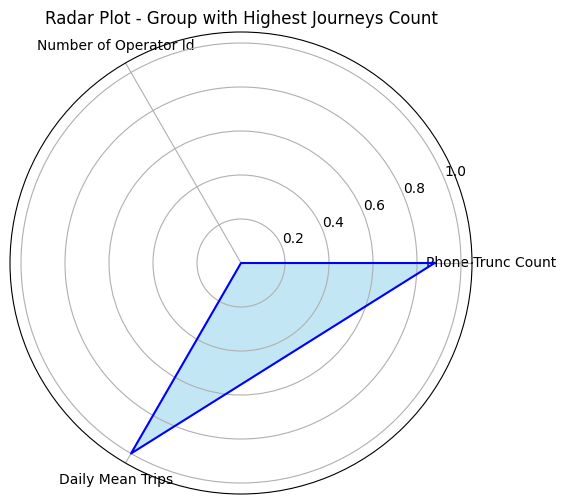

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Get the group with the highest Journeys Count
group_max_journeys = groups_df[groups_df['Journeys Count'] == groups_df['Journeys Count'].max()]

# Get the relevant data for radar plot
labels = ['Phone Trunc Count', 'Number of Operator Id', 'Daily Mean Trips']
values = group_max_journeys[['Phone Trunc Count','Number of Operator Id', 'Daily mean trips']].values.flatten()

# Perform Min-Max scaling on the values
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()



# Extend the scaled values array to match the length of labels
values_scaled = np.append(values_scaled, values_scaled[0])

# Calculate the angle for each axis
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Create the radar plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values_scaled, color='skyblue', alpha=0.5)
ax.plot(angles, values_scaled, color='blue', linewidth=1.5)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.yaxis.grid(True)

# Add a title
plt.title('Radar Plot - Group with Highest Journeys Count', fontsize=12)

# Display the plot
plt.show()


In [1]:
groups_df

NameError: name 'groups_df' is not defined

In [ ]:
groups_df.columns